<a href="https://colab.research.google.com/github/stunnedbud/CursoRedesProfundas/blob/main/Tarea2_Ejercicio2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2. Ejercicio 2
## Predicción de edades



## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
# Colab
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os
import glob
# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
# inspección de arquitectura
# https://github.com/TylerYep/torch-summary
from torchsummary import summary
# barras de progreso
from tqdm import tqdm
# imágenes
from PIL import Image

### 1.2. Auxiliares

In [3]:
# directorio de datos
URL =  'https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download'
base_dir = '../data/faces'
filename = 'UTKFace.tar.gz'
data_dir = '../data/faces/UTKFace'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 12
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 2, 6
# Dimensiones originales de la imagen
IM_WIDTH = IM_HEIGHT = 198
# tamaño de la imagen despues de recortado
IMG_SIZE = 64
# Tamaño de conjunto de datos
TRAIN_TEST_SPLIT = 0.8

dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())


def parse_info_from_file(path):
    """
    Parse information from a single file
    """
    try:
        filename = os.path.split(path)[1]
        filename = os.path.splitext(filename)[0]
        age, gender, race, _ = filename.split('_')

        return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
    except Exception as ex:
        return None, None, None

def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """   
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    print(files[0])
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch
<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/e9fbbe09478011ee08fe45ce2afb63db3fa2c8df/figs/comida_datos.svg" width="1050"/>
&nbsp;
Tuberia de datos para Recipes2k, misma que usaremos para UTKFace.

### 2.2 Descarga de UTKFace

In [4]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

File ‘../data/faces/UTKFace.tar.gz’ already there; not retrieving.


### 2.3 Conjunto de datos

In [5]:
df = parse_dataset(data_dir) 
df.head(5)

../data/faces/UTKFace/26_1_1_20170116224135754.jpg.chip.jpg


,age,gender,race,file
0,26.0,female,black,../data/faces/UTKFace/26_1_1_20170116224135754...
1,1.0,female,asian,../data/faces/UTKFace/1_1_2_20161219211944925....
2,26.0,female,indian,../data/faces/UTKFace/26_1_3_20170104232408872...
3,22.0,male,black,../data/faces/UTKFace/22_0_1_20170102233341092...
4,44.0,female,indian,../data/faces/UTKFace/44_1_3_20170119164705141...


### 2.3.1 Etiquetas

En este conjunto de datos las etiquetas de cada ejemplo están embebidas en el nombre de archivo de cada imagen, formateado así:

    [age] _ [gender] _ [race] _ [date&time].jpg

Donde:

    [age] is an integer from 0 to 116, indicating the age
    [gender] is either 0 (male) or 1 (female)
    [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
    [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [6]:
! ls {data_dir} | head -5

100_0_0_20170112213500903.jpg.chip.jpg
100_0_0_20170112215240346.jpg.chip.jpg
10_0_0_20161220222308131.jpg.chip.jpg
10_0_0_20170103200329407.jpg.chip.jpg
10_0_0_20170103200522151.jpg.chip.jpg


In [7]:
class FacesDS:

    def __init__(self, df, tsfm):
          
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []

        # parseamos el dataframe 
        for ind in df.index:
            self.paths.append(df["file"][ind])
            self.labels.append(df["age"][ind])

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

### 2.4 Exploración

x shape=torch.Size([12, 64, 64, 3]) dtype=torch.uint8
y shape=torch.Size([12, 1]) dtype=torch.float32


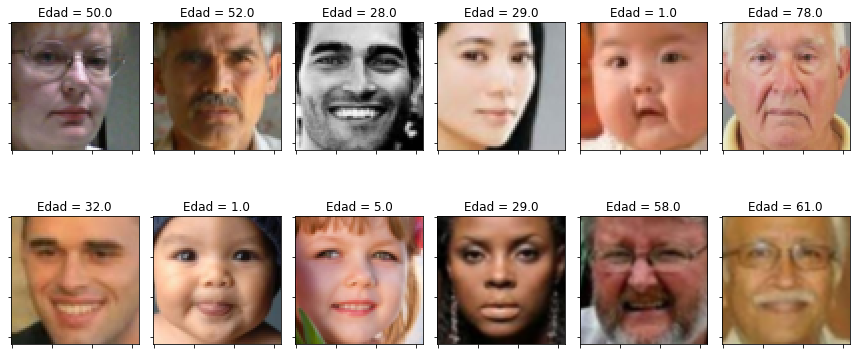

In [8]:
tsfm = transforms.Compose([
    # recortamos al centro a 200x200
    transforms.CenterCrop(200),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # Aqui aun no aumentamos los datos, solo es exploración
    # convertimos a ndarray
    np.array
])

ds = FacesDS(df, tsfm)
#ds = RecipesDS(data_dir, tsfm)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_grid(x, titles, ROWS, COLS)

### 2.3 Cargador de datos

#### Entrenamiento

x shape=torch.Size([12, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([12, 1]) dtype=torch.float32


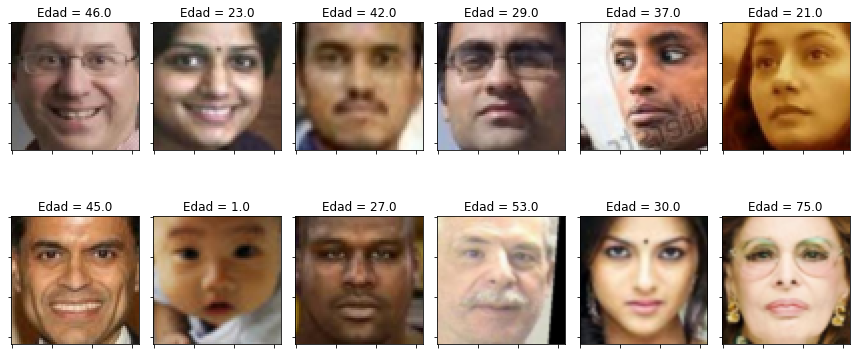

In [9]:
tsfm = transforms.Compose([
    # recortamos al centro a 200x200
    transforms.CenterCrop(200),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
     # aumentado de datos
    # espejeo horizontal aleatorio
    transforms.RandomHorizontalFlip(),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
])



train=df.sample(frac=0.8,random_state=0)
test=df.drop(train.index)

trn_ds = FacesDS(train, tsfm)
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

tst_ds = FacesDS(test, tsfm)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'Edad = {l.item()}' for l in y]
display_batch(x, titles, ROWS, COLS)

## 3 Modelo

<!-- ![arch](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/fc.jpg) -->

### 3.1 Definición de bloque ConvNeXt

La arquitectura ConvNeXt fue propuesta en el articulo "A ConvNet for the 2020s" (https://arxiv.org/abs/2201.03545) que propone diversas mejoras al bloque ResNet, logrando una arquitectura que mejora el desempeño de arquitecturas basadas en Transformadores, como SWIN, pero también escala con la cantidad de datos.

En la figura vemos qué tanto mejoró el modelo ResNet con cada cambio implementado hasta llegar a ConvNeXt, y cómo se compara con SWIN:

<img src="https://miro.medium.com/max/720/0*evJWJZCri0xHLqHU.png" width="460"/>


In [19]:
class ConvNeXtBlock(nn.Module):

    def __init__(self, in_channels, out_channels): 
        super(ConvNeXtBlock, self).__init__()
        
        # [N, I, H, W] => [N, O2, H, W]
        self.cnn_block = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=7, 
                      kernel_size=3, padding=1),
            nn.LayerNorm((7, 64, 64)),
            
            # conv2
            nn.Conv2d(in_channels=7, 
                      out_channels=1,
                      kernel_size=3, padding=1),
            nn.GELU(),

            # conv3
            nn.Conv2d(in_channels=1, 
                      out_channels=out_channels,
                      kernel_size=3, padding=1),
            # [N, O2, H, W]
        )

    def forward(self, x):
        # [N, I, H, W] => [N, O2, H, W]
        x1 = self.cnn_block(x)
        # [N, O2, H, W]
        x = x1 + x
        return x


### 3.1 Definición de la arquitectura

Se conservó la arquitectura del ejemplo Recipes2k con datos de alimentos, pero cambiando los bloques ResNet por ConvNeXt:

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/c40334469ccae2911fba0cc15492364e0cebc2c9/figs/resnet_arq.svg" width="250"/>

In [20]:
from torch.nn import functional as func

class MicroResNet(nn.Module):

    def __init__(self):
        super(MicroResNet, self).__init__()
        self.num_feats = 3 * 32 * 32
        
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        self.cnn = nn.Sequential(
            # [N, 3, 64, 64] => [N, 3, 64, 64]
            ConvNeXtBlock(in_channels=3, out_channels=3),
            # [N, 3, 64, 64] => [N, 3, 32, 32]
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # [N, 3, 32, 32] => [N, 3x32x32]
        self.flatten = nn.Flatten()

        # [N, 3x32x32] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 1)

    def forward(self, x):
        # [N, 3, 64, 64] => [N, 3, 32, 32]
        #print("inputx")
        #print(x)
        x = self.cnn(x)
        #print("convnext")
        print(x)
        # [N, 3, 32, 32] => [N, 3x32x32]
        x = self.flatten(x)
        # [N, 3x32x32] => [N, 1]
        x = self.cls(x)
        return x

    def predict(self, x):
        # [N, 3, 64, 64] => [N, 1]
        y_lgts = self.forward(x)
        # [N, 1]
        # ReLU porque queremos predecir en un rango numerico n > 0
        # en lugar de (0,1) como haria una sigmoide
        y_prob = nn.ReLU(y_lgts) #torch.sigmoid(y_lgts)
        return y_prob

### 3.2 Inspección de la arquitectura

In [21]:
model = MicroResNet()
summary(model, (3, 64, 64), device='cpu')

tensor([[[[0.8473, 0.8226, 0.7936,  ..., 0.7581, 0.7241, 1.0672],
          [0.8894, 0.9200, 0.6822,  ..., 0.8958, 0.8190, 0.7639],
          [0.9418, 0.9342, 0.9716,  ..., 0.8157, 0.6671, 0.9101],
          ...,
          [0.8699, 0.4921, 0.8563,  ..., 0.9687, 0.9021, 0.9589],
          [0.5342, 1.0420, 0.6626,  ..., 0.8095, 0.9581, 1.0101],
          [0.6214, 0.7466, 0.8286,  ..., 0.9422, 0.9756, 0.9661]],

         [[1.0808, 1.0880, 1.1687,  ..., 0.9607, 0.5654, 1.1058],
          [0.9664, 1.1488, 1.1152,  ..., 0.9698, 1.0378, 1.0443],
          [1.0630, 1.1031, 0.9585,  ..., 1.1694, 1.1131, 0.9358],
          ...,
          [1.1642, 1.1277, 1.0787,  ..., 1.0369, 1.1843, 1.1165],
          [1.0626, 1.2041, 1.1005,  ..., 1.1879, 0.9735, 1.1614],
          [0.8638, 0.9016, 1.2017,  ..., 0.9754, 0.9083, 1.1591]],

         [[0.9020, 1.0307, 1.3106,  ..., 1.2010, 1.0663, 1.2815],
          [1.2496, 0.9373, 0.8152,  ..., 1.1347, 1.3622, 0.9261],
          [1.3434, 0.9533, 1.1783,  ..., 0

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 32, 32]           --
|    └─ConvNeXtBlock: 2-1                [-1, 3, 64, 64]           --
|    |    └─Sequential: 3-1              [-1, 3, 64, 64]           57,634
|    └─MaxPool2d: 2-2                    [-1, 3, 32, 32]           --
├─Flatten: 1-2                           [-1, 3072]                --
├─Linear: 1-3                            [-1, 1]                   3,073
Total params: 60,707
Trainable params: 60,707
Non-trainable params: 0
Total mult-adds (M): 1.26
Input size (MB): 0.05
Forward/backward pass size (MB): 0.56
Params size (MB): 0.23
Estimated Total Size (MB): 0.84

### 3.3 Prueba de la arquitectura

In [23]:
# inferencia con datos sinteticos
x = torch.zeros(1, 3, 64, 64)
y = model(x)
print(y.shape)
print(y)

tensor([[[[ 0.0409,  0.0317,  0.0317,  ...,  0.0317,  0.0317,  0.0354],
          [ 0.0350,  0.0320,  0.0320,  ...,  0.0320,  0.0320,  0.0338],
          [ 0.0350,  0.0320,  0.0320,  ...,  0.0320,  0.0320,  0.0338],
          ...,
          [ 0.0350,  0.0320,  0.0320,  ...,  0.0320,  0.0320,  0.0338],
          [ 0.0350,  0.0320,  0.0320,  ...,  0.0320,  0.0320,  0.0338],
          [-0.0518, -0.0525, -0.0525,  ..., -0.0525, -0.0525, -0.0263]],

         [[ 0.2236,  0.2099,  0.2099,  ...,  0.2099,  0.2099,  0.2175],
          [ 0.2054,  0.2098,  0.2098,  ...,  0.2098,  0.2098,  0.2103],
          [ 0.2054,  0.2098,  0.2098,  ...,  0.2098,  0.2098,  0.2103],
          ...,
          [ 0.2054,  0.2098,  0.2098,  ...,  0.2098,  0.2098,  0.2103],
          [ 0.2054,  0.2098,  0.2098,  ...,  0.2098,  0.2098,  0.2103],
          [ 0.2634,  0.2702,  0.2702,  ...,  0.2702,  0.2702,  0.2785]],

         [[ 0.3544,  0.3524,  0.3524,  ...,  0.3524,  0.3524,  0.3425],
          [ 0.3087,  0.2781,  

## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/10c165ec21ef9d52c7b2e7648891f3a2c5d71d95/figs/comida_entrenamiento.svg" width="650"/>


### 4.1 Ciclo de entrenamiento

In [16]:
def train_epoch(dl, model, opt):
    model.train()
    # por cada lote
    for x, y_true in dl:
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):
    model.eval()
    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            #y_prob = torch.sigmoid(y_lgts)
            # computamos las clases
            #y_pred = torch.round(y_prob)
            y_pred = func.relu(y_lgts)
            print(y_lgts)
            print(y_pred)
            print(y_true)

            # computamos la pérdida
            loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)
            print(loss)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        print(losses)
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, lr=1e-4, epochs=10,
          trn_batches=32):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

    return loss_hist, acc_hist

## 5. Pruebas del modelo

***Desafortunadamente en éste paso encontré un bug que no logré resolver. El código se ejecuta correctamente pero por algún motivo en la fase de entrenamiento los pesos de la celda ConvNeXt solo continuan creciendo y creciendo, hasta llegar todos a valores de "NaN" y se rompe el modelo.*** 

In [24]:
train(model, trn_dl)

Streaming output truncated to the last 5000 lines.
         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., 

KeyboardInterrupt: ignored

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]])
tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan,

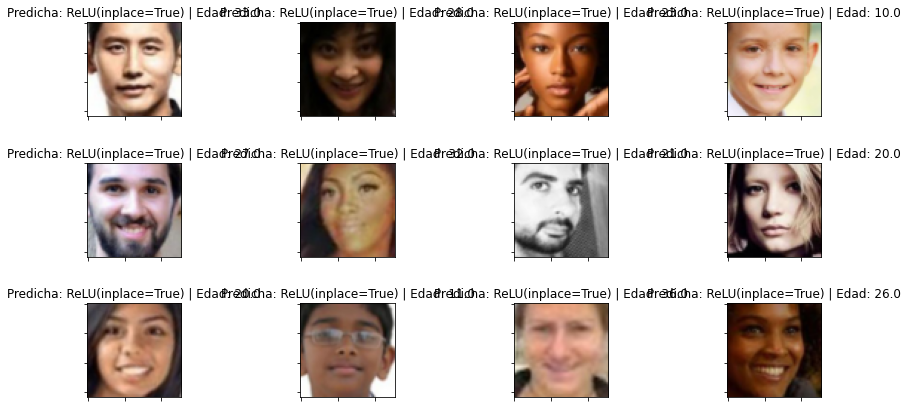

In [25]:
# desplegamos resultados
imgs = []
titles = []
model.eval()
true_titles = []
stop = False
with torch.no_grad():
    for batchx, y in dl:
        if stop:
            break
        else:
          stop = True
        true_titles += [f'Edad: {l.item()}' for l in y]
        for img_torch in batchx:
            imgs.append(img_torch)
            img_torch = img_torch.permute(2, 0, 1)
            img_torch = img_torch.float()
            img_torch = img_torch.unsqueeze(0)
            age = model.predict(img_torch)
            titles.append(f'Predicha: {age}')
full_titles = []
for i in range(len(titles)):
    full_titles.append( titles[i]+" | "+true_titles[i] )

display_grid(imgs, full_titles, 3, 4)